<a href="https://colab.research.google.com/github/mjhoover1/Robust_MAML/blob/main/Omniglot_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import os
import random
import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from tqdm import tqdm
from time import sleep
from collections import OrderedDict
from more_itertools import chunked
from torchvision.datasets import Omniglot

In [13]:
n_shot = 1
n_class = 10
n_local_update = 5
batch_size = n_class

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
ds = Omniglot('data/', download=True)

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting data/omniglot-py/images_background.zip to data/omniglot-py


In [96]:
class OmniglotNet(nn.Module):
    def __init__(self, n_class):
        super(OmniglotNet, self).__init__()
        
        self.h=105
        self.conv1 = nn.Conv2d(1, self.h, kernel_size=3)
        self.conv2 = nn.Conv2d(self.h, self.h, kernel_size=3)
        self.conv3 = nn.Conv2d(self.h, self.h, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn2 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn3 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.fc = nn.Linear(self.h, n_class)
        
        # init is very very important!!!
        # no init version -> HASH:ef56239
        init.xavier_normal_(self.conv1.weight)
        init.constant_(self.conv1.bias, 0)
        init.xavier_normal_(self.conv2.weight)
        init.constant_(self.conv2.bias, 0)
        init.xavier_normal_(self.conv3.weight)
        init.constant_(self.conv3.bias, 0)
        
        init.constant_(self.bn1.weight, 1)
        init.constant_(self.bn1.bias, 0)
        init.constant_(self.bn2.weight, 1)
        init.constant_(self.bn2.bias, 0)
        init.constant_(self.bn3.weight, 1)
        init.constant_(self.bn3.bias, 0)
        
        init.normal_(self.fc.weight, 0, 0.01)
        init.constant_(self.fc.bias, 1) # not 0 but 1.
        
    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        print(x.shape)
        # x = x.view(x.shape[0]*x.shape[1],*x.shape[2:])
        #x = x.view(x.size(0), self.h)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        
        return x

    # for MAML local optimization
    def manual_forward(self, x, params):
        
        x = F.conv2d(x, params['conv1.weight'].to(device), params['conv1.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn1.weight'], params['bn1.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = F.conv2d(x, params['conv2.weight'].to(device), params['conv2.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn2.weight'], params['bn2.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = F.conv2d(x, params['conv3.weight'].to(device), params['conv3.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn3.weight'], params['bn3.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = x.view(x.size(0), self.h, -1)
        x = F.linear(x, params['fc.weight'].to(device), params['fc.bias'].to(device))
        x = F.log_softmax(x, dim=1)
        
        return x

In [90]:
# class OmniglotNet(nn.Module):
#     '''
#     The base model for few-shot learning on Omniglot
#     '''

#     def __init__(self, num_classes, loss_fn, num_in_channels=3):
#         super(OmniglotNet, self).__init__()
#         # Define the network
#         self.features = nn.Sequential(OrderedDict([
#                 ('conv1', nn.Conv2d(num_in_channels, 64, 3)),
#                 ('bn1', nn.BatchNorm2d(64, momentum=1, affine=True)),
#                 ('relu1', nn.ReLU(inplace=True)),
#                 ('pool1', nn.MaxPool2d(2,2)),
#                 ('conv2', nn.Conv2d(64,64,3)),
#                 ('bn2', nn.BatchNorm2d(64, momentum=1, affine=True)),
#                 ('relu2', nn.ReLU(inplace=True)),
#                 ('pool2', nn.MaxPool2d(2,2)),
#                 ('conv3', nn.Conv2d(64,64,3)),
#                 ('bn3', nn.BatchNorm2d(64, momentum=1, affine=True)),
#                 ('relu3', nn.ReLU(inplace=True)),
#                 ('pool3', nn.MaxPool2d(2,2))
#         ]))
#         self.add_module('fc', nn.Linear(64, num_classes))
        
#         # Define loss function
#         self.loss_fn = loss_fn

#         # Initialize weights
#         self._init_weights()

#     def forward(self, x, weights=None):
#         ''' Define what happens to data in the net '''
#         if weights == None:
#             x = self.features(x)
#             x = x.view(x.size(0), 64)
#             x = self.fc(x)
#         else:
#             x = conv2d(x, weights['features.conv1.weight'], weights['features.conv1.bias'])
#             x = batchnorm(x, weight = weights['features.bn1.weight'], bias = weights['features.bn1.bias'], momentum=1)
#             x = relu(x)
#             x = maxpool(x, kernel_size=2, stride=2) 
#             x = conv2d(x, weights['features.conv2.weight'], weights['features.conv2.bias'])
#             x = batchnorm(x, weight = weights['features.bn2.weight'], bias = weights['features.bn2.bias'], momentum=1)
#             x = relu(x)
#             x = maxpool(x, kernel_size=2, stride=2) 
#             x = conv2d(x, weights['features.conv3.weight'], weights['features.conv3.bias'])
#             x = batchnorm(x, weight = weights['features.bn3.weight'], bias = weights['features.bn3.bias'], momentum=1)
#             x = relu(x)
#             x = maxpool(x, kernel_size=2, stride=2) 
#             x = x.view(x.size(0), 64)
#             x = linear(x, weights['fc.weight'], weights['fc.bias'])
#         return x

#     def net_forward(self, x, weights=None):
#         return self.forward(x, weights)
    
#     def _init_weights(self):
#         ''' Set weights to Gaussian, biases to zero '''
#         torch.manual_seed(1337)
#         torch.cuda.manual_seed(1337)
#         torch.cuda.manual_seed_all(1337)
#         print('init weights')
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, math.sqrt(2. / n))
#                 if m.bias is not None:
#                     m.bias.data.zero_()
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()
#             elif isinstance(m, nn.Linear):
#                 n = m.weight.size(1)
#                 m.weight.data.normal_(0, 0.01)
#                 #m.bias.data.zero_() + 1
#                 m.bias.data = torch.ones(m.bias.data.size())
    
#     def copy_weights(self, net):
#         ''' Set this module's weights to be the same as those of 'net' '''
#         # TODO: breaks if nets are not identical
#         # TODO: won't copy buffers, e.g. for batch norm
#         for m_from, m_to in zip(net.modules(), self.modules()):
#             if isinstance(m_to, nn.Linear) or isinstance(m_to, nn.Conv2d) or isinstance(m_to, nn.BatchNorm2d):
#                 m_to.weight.data = m_from.weight.data.clone()
#                 if m_to.bias is not None:
#                     m_to.bias.data = m_from.bias.data.clone()

In [64]:
def train(model, device, train_data_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for data, target in train_data_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.max(1, keepdim=True)[1]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += pred.eq(target.view_as(pred)).sum().item()
    
    train_loss /= len(train_data_loader.dataset)
    train_acc /= len(train_data_loader.dataset)
    return train_loss, train_acc

In [65]:
def test(model, device, test_data_loader):
    model.eval()
    test_loss = 0
    test_acc = 0
    
    with torch.no_grad():
        for data, target in test_data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1]
            
            test_loss += loss
            test_acc += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_data_loader.dataset)
    test_acc /= len(test_data_loader.dataset)
    return test_loss, test_acc

In [66]:
class OmniglotOriginDataset(Dataset):
    def __init__(self, path_to_lang, n_class, train, train_index, transform):

        self.data = []
        self.path = path_to_lang
        
        labels = sorted(os.listdir(path_to_lang))[:n_class]
        
        for label_i, label in enumerate(labels):
            path_to_label = os.path.join(path_to_lang, label)
            chars = np.array(sorted(os.listdir(path_to_label)))
            if train:
                chars = chars[train_index]
            else:
                test_index = list(set(np.arange(20)) - set(train_index)) # omniglot has 20 images per character
                chars = chars[test_index]
            for char in chars:
                path_to_char = os.path.join(path_to_label, char)
                image = io.imread(path_to_char)
                label_i = np.array(label_i)
                self.data.append([image, label_i])
            
        self.transform = transform
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        return self.transform(self.data[idx])

In [67]:
class ToTensor(object):
    def __call__(self, sample):
        image, label = sample[0], sample[1]
        image = image / 255
        image = (image-0.92208)/0.25140
        image = image.reshape([105,105, 1])
        image = image.transpose((2, 0, 1))
        image = np.array(image, np.float32)

        return [torch.from_numpy(image), torch.from_numpy(label)]

In [68]:
class OmniglotAugmentedDataset(Dataset):
    def __init__(self, path_to_chars, train, train_indices, transform):

        self.data = []
        self.path = NotImplementedError
        
        for label_i, (path_to_label, train_index) in enumerate(zip(path_to_chars, train_indices)):
            chars = np.array(sorted(os.listdir(path_to_label)))
            if train:
                chars = chars[train_index]
            else:
                test_index = list(set(np.arange(20)) - set(train_index)) # omniglot has 20 images per character
                chars = chars[test_index]
            for char in chars:
                path_to_char = os.path.join(path_to_label, char)
                image = io.imread(path_to_char)
                label_i = np.array(label_i)
                self.data.append([image, label_i])
            
        self.transform = transform
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        return self.transform(self.data[idx])

local_task_train_data
/content/data/omniglot-py/images_background/Latin/


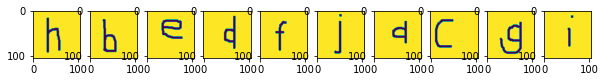

y_true: tensor([7, 1, 4, 3, 5, 9, 0, 2, 6, 8])

local_task_test_data


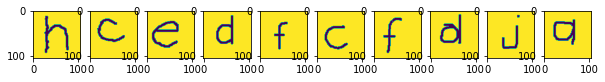

y_true: tensor([7, 2, 4, 3, 5, 2, 5, 3, 9, 0])


In [97]:
local_task_train_data_loader = DataLoader(
    OmniglotOriginDataset("/content/data/omniglot-py/images_background/Latin/", 
                    n_class=n_class,
                    train=True,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

print("local_task_train_data")
print(local_task_train_data_loader.dataset.path)

for data, target in local_task_train_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)
    
print("\nlocal_task_test_data")
local_task_test_data_loader = DataLoader(
    OmniglotOriginDataset("/content/data/omniglot-py/images_background/Latin", 
                    n_class=n_class,
                    train=False,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

for data, target in local_task_test_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)
    break

In [98]:
local_task_train_data_loader = DataLoader(
    OmniglotOriginDataset("/content/data/omniglot-py/images_background/Latin/", 
                    n_class=n_class,
                    train=True,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)


local_task_test_data_loader = DataLoader(
    OmniglotOriginDataset("/content/data/omniglot-py/images_background/Latin/", 
                    n_class=n_class,
                    train=False,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)

model = OmniglotNet(n_class=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

with tqdm(range(10)) as _tqdm:
    for epoch in _tqdm:
        train_loss, train_acc = train(model, device, local_task_train_data_loader, optimizer, epoch)
        test_loss, test_acc = test(model, device, local_task_test_data_loader)
        _tqdm.set_postfix(OrderedDict(
            epoch=epoch+1, 
            train_loss=train_loss, train_acc=train_acc, 
            test_loss=test_loss, test_acc=test_acc))
        

data, target = local_task_train_data_loader.__iter__().next()

images = np.array(data).reshape(10,28,28)
plt.figure(figsize=(10,1))
[[plt.subplot(1,10,i+1), plt.imshow(img)] for i, img in enumerate(images)]; plt.show()

print("y_pred:", torch.argmax(model(data.cuda()), 1).cpu())
print("y_true:", target)

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([10, 105, 11, 11])


RuntimeError: ignored

In [24]:
%cd ..

/content


In [32]:
%ls

 Alphabet_of_the_Magi/
 Anglo-Saxon_Futhorc/
 Arcadian/
 Armenian/
'Asomtavruli_(Georgian)'/
 Balinese/
 Bengali/
'Blackfoot_(Canadian_Aboriginal_Syllabics)'/
 Braille/
'Burmese_(Myanmar)'/
 Cyrillic/
 Early_Aramaic/
 Futurama/
 Grantha/
 Greek/
 Gujarati/
 Hebrew/
'Inuktitut_(Canadian_Aboriginal_Syllabics)'/
'Japanese_(hiragana)'/
'Japanese_(katakana)'/
 Korean/
 Latin/
'Malay_(Jawi_-_Arabic)'/
'Mkhedruli_(Georgian)'/
 N_Ko/
'Ojibwe_(Canadian_Aboriginal_Syllabics)'/
 Sanskrit/
'Syriac_(Estrangelo)'/
 Tagalog/
 Tifinagh/


In [27]:
%cd data

/content/data


In [29]:
%cd omniglot-py/

/content/data/omniglot-py


In [31]:
%cd images_background/

/content/data/omniglot-py/images_background


In [34]:
%cd Latin

/content/data/omniglot-py/images_background/Latin
